In [1]:
# ===================================================================
#                          METADATA
# ===================================================================

# -------------------- General Information --------------------------
# 1. Title: Figure Script
# 2. Description: Script to reproduce Figure 3 and SI4 in the article
# "Ionic Liquid--Electrode Interface: from One Law To Fit Them All to One Model To Predict Them All".
# 3. Authors:
#    - Ba Long Nguyen (ORCID: 0009-0003-7682-9851)
#    - Vladislav Ivanistsev (ORCID: 0000-0003-4517-0540)
# 4. Contact: balongn99@gmail.com & vladislav.ivanistsev@gmail.com
# 5. Keywords: differential capacitance, ionic liquids, modelling, fitting.

# -------------------- Identifiers & Versioning ---------------------
# 6. Version: 1.0.0
# 7. Date: 
#    - Created: 2025-06-13
#    - Last Modified: 2025-09-24
# 8. DOI: https://doi.org/10.1016/j.elecom.2025.108049

# -------------------- Usage & Accessibility ------------------------
# 10. License: This work is licensed under the MIT License.
# 11. Dependencies:
#     - Python 3.8+
#     - See 'requirements.txt' for necessary libraries (e.g., numpy, pandas, scipy, matplotlib).
# 13. Data Format:
#     - Units: Potential (V), Capacitance (μF/cm²), Surface Charge Density (μC/cm²)

In [2]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import numdifftools as nd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

fw = 17/2.54  # inches
fh =  7/2.54  # inches
bw = 4.5/2.54 # inches (box width and height)
gw =   1/2.54 # inches (gap between boxes)

plt.rc('figure',figsize=(fw,fh))       # figure size
plt.rc('figure',      dpi=133)         # figure dpi
plt.rc('lines',  linewidth=1)          # linewidth
plt.rc('font',        size=10)         # fontsize of the text
plt.rc('font', family='sans-serif')    # font family
plt.rc('axes',   titlesize=10)         # fontsize of the axes title
plt.rc('axes',   labelsize=9)          # fontsize of the x and y labels
plt.rc('xtick',  labelsize=8)          # fontsize of the tick labels
plt.rc('ytick',  labelsize=8)          # fontsize of the tick labels
plt.rc('legend', fontsize =8)          # fontsize of the legend
plt.rc('figure', titlesize=10)         # fontsize of the figure title

In [6]:
# ──────────────────── POWER-LAW MODEL ────────────────────
EXCLUDE = np.nan
def a(u, u_M, s_M, k1, k2):
    expo = k1 + (1 - k1) * np.exp(-k2 * u / u_M)
    if s_M > 0:                         # only right half-plane allowed
        expo = np.where(u >= 0, expo, EXCLUDE)
    else:                               # only left half-plane allowed
        expo = np.where(u <= 0, expo, EXCLUDE)
    return expo

def s_vec(u, u_M, s_M, k1, k2):
    return s_M * (u / u_M)**a(u, u_M, s_M, k1, k2)

def s_wrapper(x, *args, **kwargs):
    return s_vec(x, *args)
  
def C(u, u_M, s_M, k1, k2):
  derivative = nd.Derivative(s_wrapper, step=1e-12)
  return derivative(u, u_M, s_M, k1, k2)

In [4]:
# ──────────────────── DATASETS ────────────────────
data_N1114TFSA = {
  "U": np.array([
    -8.9566823, -8.2478534, -7.5539807, -6.893926, -6.2196714, -5.5059203,
    -4.8100116, -4.1775398, -3.4441147, -2.8285412, -2.2661154, -1.718025,
    -1.2206901, -0.86129428, -0.44734986, -0.12596974, 0.20473219, 0.56724145,
    0.94385464, 1.3417375, 1.6843227, 2.1589204, 2.6623967, 3.1896993,
    3.6999483, 4.3729092, 5.1801261, 5.9271759, 6.9324836, 7.8293742, 8.720207
]),
  "C": np.array([
    4.0440597, 4.2699344, 4.4371021, 4.4434628, 4.4061309, 4.4277104, 4.403857,
    4.5079396, 4.7067409, 4.9690282, 5.4515596, 6.0836948, 6.7411088, 7.6555108,
    8.4480979, 8.6335089, 8.7168063, 8.2449322, 8.1143354, 7.7211142, 7.1213932,
    6.4818836, 5.9850114, 5.5431609, 4.8718318, 4.3559651, 3.7779067, 3.4962842,
    3.3728672, 3.2710784, 3.2918675
]),
  "dC": np.array([
    0.048239195, 0.021492575, 0.01773176, 0.034016327, 0.020275244,
    0.047142588, 0.064669462, 0.073382852, 0.097048716, 0.059920953,
    0.019793531, 0.10805177, 0.15825102, 0.18622275, 0.17393211,
    0.22257698, 0.028241537, 0.022404077, 0.11721826, 0.20736835,
    0.16374179, 0.11214443, 0.040034989, 0.1161786, 0.094479814,
    0.10253857, 0.076653153, 0.075149379, 0.084504154, 0.04054821,
    0.031657104
])
}
data_N1144TFSA = {
  "U": np.array([
    -8.8654072, -7.9306557, -7.0050661, -6.1780256, -5.4940108, -4.666761,
    -3.8733266, -3.1571084, -2.3580143, -1.7975436, -1.2521956, -0.81373714,
    -0.4094232, -0.057718006, 0.28247906, 0.6662099, 1.0233817, 1.3942538,
    1.7239589, 2.2702502, 2.7017659, 3.1950107, 3.737417, 4.3554723,
    5.0972423, 6.0656409, 6.8587863
]),
  "C": np.array([
    3.0441661, 3.2481886, 3.5657465, 3.7689075, 3.8969208, 3.9540713, 3.8935489,
    4.1769831, 4.5893008, 5.2306263, 6.2075039, 7.009428, 7.9203937, 8.2969356,
    8.4406954, 8.3125825, 8.3906745, 7.7516559, 7.1579263, 6.616438, 6.1187754,
    5.8196756, 5.0907541, 4.266671, 3.8089723, 3.454309, 3.3070536
]),
  "dC": np.array([
    0.0455846, 0.01767655, 0.039734544, 0.090192538, 0.073133347, 0.082483908,
    0.049458109, 0.099132595, 0.11216115, 0.11354059, 0.05854256, 0.073762804,
    0.046726256, 0.1544541, 0.082359485, 0.082520473, 0.063849271, 0.3294166,
    0.28049373, 0.25208701, 0.15630168, 0.016031754, 0.045311861, 0.064660344,
    0.11975131, 0.082470792, 0.20614735
])
}
data_N1444TFSA = {
  "U": np.array([
    -8.3471953, -7.3284585, -6.3323917, -5.3935963, -4.4607511, -3.6253825,
    -2.8072444, -1.9518697, -1.492276, -1.2818577, -0.9988757, -0.7828346,
    -0.56227069, -0.34848205, -0.17995929, -0.019204594, 0.095999847,
    0.34901804, 0.49749229, 0.711711, 0.86740834, 1.0766674, 1.1570238,
    1.3724832, 1.8167261, 2.247584, 2.7208152, 3.2875645, 3.762309,
    4.5039261, 5.148517
]),
  "C": np.array([
    2.835326, 2.9506751, 3.102149, 3.2514403, 3.4598331, 3.5954313, 3.5663506,
    3.9684596, 4.5572039, 5.3499249, 6.4213386, 6.5765571, 7.3102311, 7.9327507,
    9.2040244, 9.0655433, 8.79109, 8.1296419, 7.9496588, 8.2993821, 8.9952376,
    9.4020184, 8.7264091, 8.2272501, 6.8495962, 6.492727, 6.1845399, 5.4065466,
    4.9598812, 4.3912146, 3.9403927
]),
  "dC": np.array([
    0.027831316, 0.02029681, 0.027033727, 0.022701913, 0.031191883,
    0.023856931, 0.02526229, 0.28119206, 0.24014217, 0.3369417,
    0.20175832, 0.13690707, 0.12681763, 0.084417118, 0.11252085,
    0.64400311, 0.61826413, 0.5300547, 0.35538246, 0.28988308,
    0.49747286, 0.77335413, 0.70254107, 0.69207398, 0.055009441,
    0.072124614, 0.068609406, 0.1464859, 0.13430493, 0.11148882,
    0.24150723
])}

df_N1114TFSA = pd.DataFrame(data_N1114TFSA)
df_N1144TFSA = pd.DataFrame(data_N1144TFSA)
df_N1444TFSA = pd.DataFrame(data_N1444TFSA)

/home/ba-long/miniconda-fresh/envs/jlab/lib/python3.12/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_11805/3879350049.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


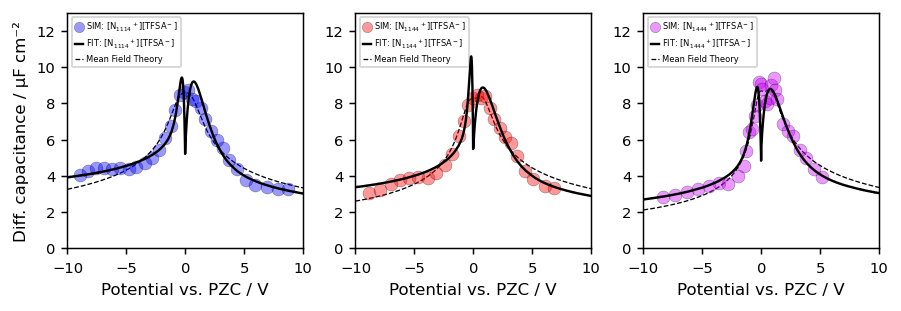

In [5]:
# ---------------------------------------------------------------------
# ANALYTIC “FIT” CURVES
# ---------------------------------------------------------------------
u_values = np.linspace(-10, 10, 1000)

# parameters
params = {  #    s_M     u_M        k1         k2
    "TFSA7":  ( 41.4, 7.7, 0.621348, 6.773745),
    "N1114": (-62.9, -13.4, 0.783932, 50.103741),
    "TFSA10":  ( 41.4, 7.7, 0.598057, 5.366269),
    "N1144": (-43.5, -9.6, 0.752002, 61.82),
    "TFSA13":  (41.4, 7.7, 0.625518, 5.883036),
    "N1444": (-30.8, -7, 0.686147, 18.020777)
}

u_grid = np.linspace(-10, 10, 1000)

C_values = {}

for ion, param in params.items():
    C_values[ion] = [C(u, param[1], param[0], param[2], param[3]) for u in u_grid]
  
joint_Cdata = {}

joint_Cdata["FIT: $[\\mathrm{N_{1114}}^+][\\mathrm{TFSA}^-]$"] = np.concatenate((np.asarray(C_values["N1114"])[~np.isnan(np.asarray(C_values["N1114"]))],
                                            np.asarray(C_values["TFSA7"])[~np.isnan(np.asarray(C_values["TFSA7"]))]
                                           ))
joint_Cdata["FIT: $[\\mathrm{N_{1144}}^+][\\mathrm{TFSA}^-]$"] = np.concatenate((np.asarray(C_values["N1144"])[~np.isnan(np.asarray(C_values["N1144"]))],
                                            np.asarray(C_values["TFSA10"])[~np.isnan(np.asarray(C_values["TFSA10"]))]
                                           ))
joint_Cdata["FIT: $[\\mathrm{N_{1444}}^+][\\mathrm{TFSA}^-]$"] = np.concatenate((np.asarray(C_values["N1444"])[~np.isnan(np.asarray(C_values["N1444"]))],
                                            np.asarray(C_values["TFSA13"])[~np.isnan(np.asarray(C_values["TFSA13"]))]
                                           ))

#-----------------------------------------------------------------------------------------
# Thermal broadening effect - uncomment this to produce Figure SI4
#-----------------------------------------------------------------------------------------
# for key in joint_Cdata:
#     joint_Cdata[key] = gaussian_filter1d(joint_Cdata[key], sigma=20)


# ------------------------------------------------------------------
# Kornyshev model 
# ------------------------------------------------------------------
k_B, e, T = 1.380649e-23, 1.602176634e-19, 423.

def kornyshev(phi, Cd0, yp, ym, alpha, CH):
    # Physical constants
    e = 1.602176634e-19    # elementary charge, C
    k_B = 1.380649e-23     # Boltzmann constant, J/K
    T = 423             # temperature, K

    Cd0_SI = Cd0 * 1e-2
    CH_SI = CH * 1e-2

    u_red  = e * phi / (k_B * T)
    gamma  = ym + (yp - ym) / (1 + np.exp(alpha*u_red))
    sinh2  = np.sinh(alpha*u_red/2)**2
    logt   = np.log1p(2*gamma*sinh2)
    logt   = np.where(logt==0, np.finfo(float).eps, logt)
    ratio  = 2*gamma*sinh2/logt
    ratio  = np.where(ratio<=0, np.finfo(float).eps, ratio)

    D = Cd0_SI * np.cosh(alpha*u_red/2)/(1+2*gamma*sinh2) * np.sqrt(ratio)
    denominator = (1/CH_SI) + (1/D)
    Cd_SI = 1/denominator
    return Cd_SI/1e-2  # back to μF/cm²

def fit_kornyshev(U, C):
    m = (U>=-10)&(U<=10)
    p0 = (np.nanmedian(C[m]), 0.6, 0.3, 0.05, 5)      # added CH initial guess
    b = ([0.1, 0.01, 0.01, 0.001, 0],                 # lower bounds
         [20,  10,   1.2, 1,     20])                 # upper bounds
    popt, _ = curve_fit(kornyshev, U[m], C[m], p0=p0, bounds=b, max_nfev=20000)
    return dict(Cd0=popt[0], yp=popt[1], ym=popt[2], alpha=popt[3], CH=popt[4])

fits={
    "$[\\mathrm{N_{1114}}^+][\\mathrm{TFSA}^-]$":fit_kornyshev(df_N1114TFSA.U.values,df_N1114TFSA.C.values),
    "$[\\mathrm{N_{1144}}^+][\\mathrm{TFSA}^-]$":fit_kornyshev(df_N1144TFSA.U.values,df_N1144TFSA.C.values),
    "$[\\mathrm{N_{1444}}^+][\\mathrm{TFSA}^-]$":fit_kornyshev(df_N1444TFSA.U.values,df_N1444TFSA.C.values)
}

# ------------------------------------------------------------------
# Plot – layout & legend
# ------------------------------------------------------------------
cols  = {"$[\\mathrm{N_{1114}}^+][\\mathrm{TFSA}^-]$": "blue",
         "$[\\mathrm{N_{1144}}^+][\\mathrm{TFSA}^-]$": "red",
         "$[\\mathrm{N_{1444}}^+][\\mathrm{TFSA}^-]$": "#cc00ffff"}

dfs   = {"$[\\mathrm{N_{1114}}^+][\\mathrm{TFSA}^-]$": df_N1114TFSA,
         "$[\\mathrm{N_{1144}}^+][\\mathrm{TFSA}^-]$": df_N1144TFSA,
         "$[\\mathrm{N_{1444}}^+][\\mathrm{TFSA}^-]$": df_N1444TFSA}

marks = {k: ("o", 7) for k in dfs}

# ---- choose limits & ticks per panel --------------------------------
ylims  = [(0, 13),         
          (0,  13),       
          (0,  13)]  

yticks = [np.arange(0, 14, 2),   # 0,5,10,…
          np.arange(0,  14, 2),   # 0,1,2,…
          np.arange(0,  14, 2)]   # 0,1,2,…

# --------------------------------------------------------------------

n_panels = len(dfs)

fig = plt.figure(figsize=(fw, fh))

axs = []
for i in range(3):
    left_in   = (0.43+i * (bw + gw))      # 1 cm initial margin
    bottom_in = (fh - bw) / 2            # center vertically

    left   = left_in / fw
    bottom = bottom_in / fh
    width  = bw / fw
    height = bw / fh

    ax = fig.add_axes([left, bottom, width, height])
    ax.set_aspect('auto')
    ax.set_xlabel("Potential vs. PZC / V")
    if i == 0:
        ax.set_ylabel("Diff. capacitance / μF cm⁻²")
    axs.append(ax)

# ---- Plotting ----
for i, (name, df) in enumerate(dfs.items()):
    ax      = axs[i]
    m, ms   = marks[name]
    color   = cols[name]

    # Plot 1: SIM
    sim_label = f"SIM: {name}"
    ax.errorbar(df.U, df.C, fmt=m, color=color,
                markersize=ms, markeredgecolor="black",
                markeredgewidth=0.3, alpha=0.4,
                label=sim_label)

    # Plot 2: FIT
    fit_label = f"FIT: {name}"
    ax.plot(u_grid, joint_Cdata[fit_label], color='black',
            lw=1.3, label=fit_label, zorder=100)

    # Plot 3: Mean Field Theory
    mft_label = "Mean Field Theory"
    ax.plot(u_grid, kornyshev(u_grid, **fits[name]),
            color="black", ls="--", lw=0.7, label=mft_label)

    ax.set_xlim(-10, 10)
    ax.set_ylim(*ylims[i])
    ax.set_yticks(yticks[i])
    ax.tick_params(axis="y", length=3)

    handles, labels = ax.get_legend_handles_labels()
    label_order = [sim_label, fit_label, mft_label]
    ordered_handles = [handles[labels.index(lab)] for lab in label_order]

    ax.legend(ordered_handles, label_order,
              loc="upper left",
              markerscale=0.8, handlelength=1, handletextpad=0.3, fontsize=4.5)

fig.tight_layout()       
# plt.savefig("Figure_3_Kata3panel.pdf.pdf", dpi=600, bbox_inches='tight')
plt.show()